In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import collections

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier

In [56]:
def get_dset(filename, label_name, col_names=None):
    dset = pd.read_csv(f'data/{filename}', header=None if col_names else 0)
    
    if col_names is not None:
        dset.columns = col_names

    X = dset.drop(label_name, axis=1).values
    y = dset[label_name]

    return X, y


In [88]:
def exp_crossvalidation_test(filename, label_name, col_names=None, title=""):
    X, y = get_dset(filename, label_name, col_names)

    # Cross validation
    n_splits_list = [2, 5, 10]
    stratify_list = [True, False]

    knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
        
    x_data = []
    f_score_data = []
    for n_splits in n_splits_list:
        for stratified in stratify_list:
            f_scores = []
            accuracies = []

            if stratified:
                kf = StratifiedKFold(n_splits = n_splits, shuffle = True)
            else:
                kf = KFold(n_splits = n_splits, shuffle = True)

            if stratified:
                for train_index, test_index in kf.split(X, y):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test) 
                    knn.fit(X_train, y_train)

                    y_pred = knn.predict(X_test)
                    f_scores.append(f1_score(y_test, y_pred, average="micro"))
                    accuracies.append(accuracy_score(y_test, y_pred))
            else:
                for train_index, test_index in kf.split(X):
                    X_train, X_test = X[train_index], X[test_index]
                    y_train, y_test = y[train_index], y[test_index]

                    scaler = StandardScaler()
                    X_train = scaler.fit_transform(X_train)
                    X_test = scaler.transform(X_test) 
                    knn.fit(X_train, y_train)

                    y_pred = knn.predict(X_test)
                    f_scores.append(f1_score(y_test, y_pred, average="micro"))
                    accuracies.append(accuracy_score(y_test, y_pred))

            x_data.append(f'{n_splits} folds{" stratified" if stratified else ""}')
            f_score_data.append(f_scores)
    
    # f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Parametry walidacji krzyzowej')
    plt.ylabel('F score')
    plt.title(f'Wplyw parametrow walidacji krzyzowej na skutecznosc k-nn dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [89]:
# def exp_crossvalidation_test(filename, label_name, col_names=None, title=""):
#     X, y = get_dset(filename, label_name, col_names)

#     # Cross validation
#     n_splits_list = [2, 5, 10]
#     stratify_list = [True, False]

#     knn = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
        
#     x_data = []
#     f_score_data = []
#     for n_splits in n_splits_list:
#         for stratified in stratify_list:
#             f_scores = []
#             accuracies = []

#             if stratified:
#                 kf = StratifiedKFold(n_splits = n_splits, shuffle = True)
#             else:
#                 kf = KFold(n_splits = n_splits, shuffle = True)

#             if stratified:
#                 for train_index, test_index in kf.split(X, y):
#                     X_train, X_test = X[train_index], X[test_index]
#                     y_train, y_test = y[train_index], y[test_index]

#                     scaler = StandardScaler()
#                     X_train = scaler.fit_transform(X_train)
#                     X_test = scaler.transform(X_test) 
#                     knn.fit(X_train, y_train)

#                     y_pred = knn.predict(X_test)
#                     f_scores.append(f1_score(y_test, y_pred, average="micro"))
#                     accuracies.append(accuracy_score(y_test, y_pred))
#             else:
#                 for train_index, test_index in kf.split(X):
#                     X_train, X_test = X[train_index], X[test_index]
#                     y_train, y_test = y[train_index], y[test_index]

#                     scaler = StandardScaler()
#                     X_train = scaler.fit_transform(X_train)
#                     X_test = scaler.transform(X_test) 
#                     knn.fit(X_train, y_train)

#                     y_pred = knn.predict(X_test)
#                     f_scores.append(f1_score(y_test, y_pred, average="micro"))
#                     accuracies.append(accuracy_score(y_test, y_pred))

#             f_score = np.mean(f_scores)
#             accuracy = np.mean(accuracies)

#             x_data.append(f'{n_splits} folds{" stratified" if stratified else ""}')
#             f_score_data.append(f_score)
    
#     f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
#     plt.figure(figsize=(10, 5))
#     plt.bar(x_data, f_score_data)
#     plt.ylim((0.8, 1))
#     plt.xlabel('Parametry walidacji krzyzowej')
#     plt.ylabel('F score')
#     plt.title(f'Wplyw parametrow walidacji krzyzowej na skutecznosc k-nn dla {title}')
#     plt.show()
    
# wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
#                   'Alcalinity of ash', 'Magnesium', 
#                   'Total phenols', 'Flavanoids', 
#                   'Nonflavanoid phenols', 'Proanthocyanins', 
#                   'Color intensity', 'Hue', 
#                   'OD280/OD315 of diluted wines', 'Proline']

# glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
#                   'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']

# exp_crossvalidation_test('iris.csv', 'variety', title='IRIS')
# exp_crossvalidation_test('wine.data', 'Class identifier', wine_col_names, title='WINE')
# exp_crossvalidation_test('glass.data', 'type', glass_col_names, title='GLASS')

In [117]:
def exp_n_neighbors_test(filename, label_name, col_names=None, title=""):
    X, y = get_dset(filename, label_name, col_names)

    # Cross validation
    n_splits = 5
    n_neighbors_list = np.arange(1, 17, 1)
    
    x_data = []
    f_score_data = []
    for n_neighbors in n_neighbors_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
        f_scores = []
        accuracies = []

        kf = StratifiedKFold(n_splits = n_splits, shuffle = True)

        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test) 
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            f_scores.append(f1_score(y_test, y_pred, average="micro"))
            accuracies.append(accuracy_score(y_test, y_pred))

        f_score = np.mean(f_scores)
        accuracy = np.mean(accuracies)

        x_data.append(n_neighbors)
        f_score_data.append(f_scores)
        # f_score_data.append(f_score)
    
    #f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Sposob glosowania')
    plt.ylabel('F score')
    plt.title(f'Wplyw sposobu glosowania w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [133]:
def exp_metric_test(filename, label_name, col_names=None, title="", n_neighbors=5, voting='uniform'):
    X, y = get_dset(filename, label_name, col_names)

    n_splits = 5
    metric_list = ['euclidean', 'manhattan', 'minkowski']
    
    x_data = []
    f_score_data = []
    for metric in metric_list:
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=voting)
        f_scores = []
        accuracies = []

        kf = StratifiedKFold(n_splits = n_splits, shuffle = True)

        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test) 
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            f_scores.append(f1_score(y_test, y_pred, average="micro"))
            accuracies.append(accuracy_score(y_test, y_pred))

        f_score = np.mean(f_scores)
        accuracy = np.mean(accuracies)

        x_data.append(metric)
        f_score_data.append(f_scores)
    
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Miara odleglosci')
    plt.ylabel('F score')
    plt.title(f'Wplyw miary odleglosci w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [134]:
def exp_voting_test(filename, label_name, col_names=None, title="", n_neighbors=5):
    X, y = get_dset(filename, label_name, col_names)

    n_splits = 5
    voting_list = ['uniform', 'distance', 'own']
    
    x_data = []
    f_score_data = []
    for voting in voting_list:
        if voting == 'own':
            voting = 'uniform' # TODO
        knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean', weights=voting)
        f_scores = []
        accuracies = []

        kf = StratifiedKFold(n_splits = n_splits, shuffle = True)

        for train_index, test_index in kf.split(X, y):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            scaler = StandardScaler()
            X_train = scaler.fit_transform(X_train)
            X_test = scaler.transform(X_test) 
            knn.fit(X_train, y_train)

            y_pred = knn.predict(X_test)
            f_scores.append(f1_score(y_test, y_pred, average="micro"))
            accuracies.append(accuracy_score(y_test, y_pred))

        f_score = np.mean(f_scores)
        accuracy = np.mean(accuracies)

        x_data.append(voting)
        f_score_data.append(f_scores)
    
    df = pd.DataFrame({'Parameters': x_data, 'F1_score (mean)': [round(np.mean(x), 2) for x in f_score_data]})
    print(df.sort_values('F1_score (mean)', ascending=False))
    plt.figure(figsize=(10, 5))
    plt.boxplot(f_score_data)
    plt.xticks(np.arange(1, len(x_data) + 1, 1), x_data)
    # plt.ylim((0.8, 1))
    plt.xlabel('Liczba sasiadow')
    plt.ylabel('F score')
    plt.title(f'Wplyw sposobu glosowania w algorytmie k-nn na jego skutecznosc dla {title}')
    plt.show()
    
wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
                  'Alcalinity of ash', 'Magnesium', 
                  'Total phenols', 'Flavanoids', 
                  'Nonflavanoid phenols', 'Proanthocyanins', 
                  'Color intensity', 'Hue', 
                  'OD280/OD315 of diluted wines', 'Proline']

glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
                  'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']


In [135]:
# def exp_n_neighbors_test(filename, label_name, col_names=None, title=""):
#     X, y = get_dset(filename, label_name, col_names)

#     # Cross validation
#     n_splits = 5
#     n_neighbors_list = np.arange(1, 17, 1)
    
#     x_data = []
#     f_score_data = []
#     for n_neighbors in n_neighbors_list:
#         knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
#         f_scores = []
#         accuracies = []

#         kf = StratifiedKFold(n_splits = n_splits, shuffle = True)

#         for train_index, test_index in kf.split(X, y):
#             X_train, X_test = X[train_index], X[test_index]
#             y_train, y_test = y[train_index], y[test_index]

#             scaler = StandardScaler()
#             X_train = scaler.fit_transform(X_train)
#             X_test = scaler.transform(X_test) 
#             knn.fit(X_train, y_train)

#             y_pred = knn.predict(X_test)
#             f_scores.append(f1_score(y_test, y_pred, average="micro"))
#             accuracies.append(accuracy_score(y_test, y_pred))

#         f_score = np.mean(f_scores)
#         accuracy = np.mean(accuracies)

#         x_data.append(n_neighbors)
#         f_score_data.append(f_score)
    
#     #f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
#     plt.figure(figsize=(10, 5))
#     plt.plot(x_data, f_score_data, 'o')
#     plt.ylim((round(min(f_score_data) - 0.1, 1), 1))
#     plt.xlabel('Liczba sasiadow')
#     plt.ylabel('F score')
#     plt.title(f'Wplyw liczby sasiadow w algorytmie k-nn na jego skutecznosc dla {title}')
#     plt.show()
    
# wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
#                   'Alcalinity of ash', 'Magnesium', 
#                   'Total phenols', 'Flavanoids', 
#                   'Nonflavanoid phenols', 'Proanthocyanins', 
#                   'Color intensity', 'Hue', 
#                   'OD280/OD315 of diluted wines', 'Proline']

# glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
#                   'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']

# exp_n_neighbors_test('iris.csv', 'variety', title='IRIS')
# exp_n_neighbors_test('wine.data', 'Class identifier', wine_col_names, title='WINE')
# exp_n_neighbors_test('glass.data', 'type', glass_col_names, title='GLASS')

In [136]:
# def exp_n_neighbors_test(filename, label_name, col_names=None, title=""):
#     X, y = get_dset(filename, label_name, col_names)

#     # Cross validation
#     n_splits = 5
#     n_neighbors_list = np.arange(1, 17, 1)
    
#     x_data = []
#     f_score_data = []
#     for n_neighbors in n_neighbors_list:
#         knn = KNeighborsClassifier(n_neighbors=n_neighbors, metric='euclidean')
#         f_scores = []
#         accuracies = []

#         kf = StratifiedKFold(n_splits = n_splits, shuffle = True)

#         for train_index, test_index in kf.split(X, y):
#             X_train, X_test = X[train_index], X[test_index]
#             y_train, y_test = y[train_index], y[test_index]

#             scaler = StandardScaler()
#             X_train = scaler.fit_transform(X_train)
#             X_test = scaler.transform(X_test) 
#             knn.fit(X_train, y_train)

#             y_pred = knn.predict(X_test)
#             f_scores.append(f1_score(y_test, y_pred, average="micro"))
#             accuracies.append(accuracy_score(y_test, y_pred))

#         f_score = np.mean(f_scores)
#         accuracy = np.mean(accuracies)

#         x_data.append(n_neighbors)
#         f_score_data.append(f_score)
    
#     #f_score_data, x_data = zip(*sorted(zip(f_score_data, x_data), reverse=True))
#     plt.figure(figsize=(10, 5))
#     plt.plot(x_data, f_score_data, 'o')
#     plt.ylim((round(min(f_score_data) - 0.1, 1), 1))
#     plt.xlabel('Liczba sasiadow')
#     plt.ylabel('F score')
#     plt.title(f'Wplyw liczby sasiadow w algorytmie k-nn na jego skutecznosc dla {title}')
#     plt.show()
    
# wine_col_names = ['Class identifier', 'Alcohol', 'Malic acid', 'Ash', 
#                   'Alcalinity of ash', 'Magnesium', 
#                   'Total phenols', 'Flavanoids', 
#                   'Nonflavanoid phenols', 'Proanthocyanins', 
#                   'Color intensity', 'Hue', 
#                   'OD280/OD315 of diluted wines', 'Proline']

# glass_col_names = ['Id', 'RI', 'Na', 'Mg', 'Al',
#                   'Si', 'K', 'Ca', 'Ba', 'Fe', 'type']

# exp_n_neighbors_test('iris.csv', 'variety', title='IRIS')
# exp_n_neighbors_test('wine.data', 'Class identifier', wine_col_names, title='WINE')
# exp_n_neighbors_test('glass.data', 'type', glass_col_names, title='GLASS')

## IRIS


            Parameters  F1_score (mean)
0   2 folds stratified             0.96
3              5 folds             0.96
1              2 folds             0.95
4  10 folds stratified             0.95
5             10 folds             0.95
2   5 folds stratified             0.94


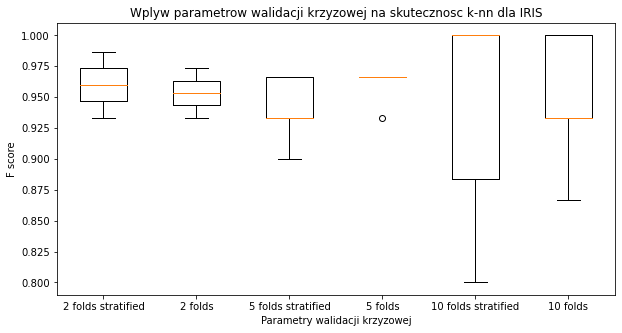

In [137]:
exp_crossvalidation_test('iris.csv', 'variety', title='IRIS')

KOMENTARZ

    Parameters  F1_score (mean)
7            8             0.97
8            9             0.97
13          14             0.97
15          16             0.97
10          11             0.96
2            3             0.95
3            4             0.95
4            5             0.95
5            6             0.95
9           10             0.95
11          12             0.95
12          13             0.95
14          15             0.95
1            2             0.94
0            1             0.93
6            7             0.93


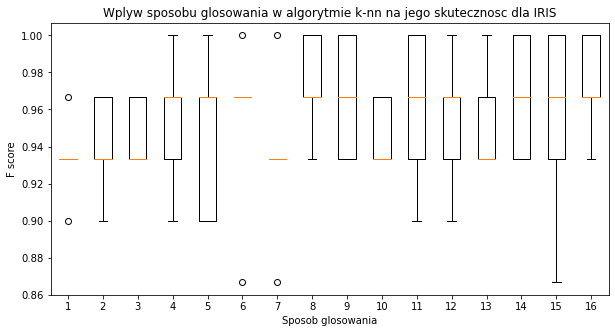

In [138]:
exp_n_neighbors_test('iris.csv', 'variety', title='IRIS')

  Parameters  F1_score (mean)
1   distance             0.95
2    uniform             0.95
0    uniform             0.93


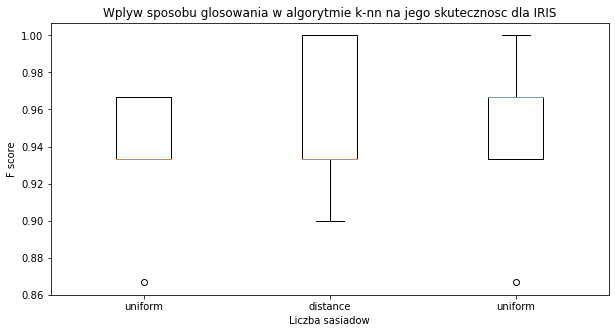

In [139]:
exp_voting_test('iris.csv', 'variety', title='IRIS', n_neighbors=5)

  Parameters  F1_score (mean)
0  euclidean             0.95
1  manhattan             0.94
2  minkowski             0.94


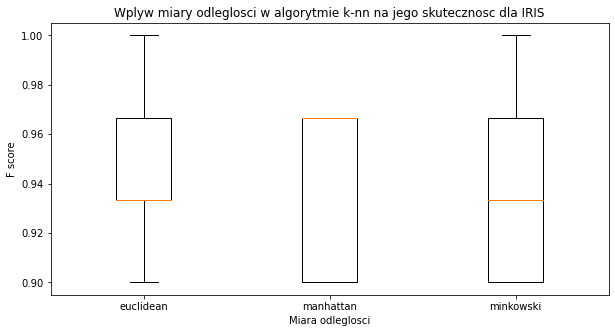

In [140]:
exp_metric_test('iris.csv', 'variety', title='IRIS', n_neighbors=5)

## WINE

            Parameters  F1_score (mean)
2   5 folds stratified             0.97
4  10 folds stratified             0.97
5             10 folds             0.97
1              2 folds             0.96
3              5 folds             0.96
0   2 folds stratified             0.94


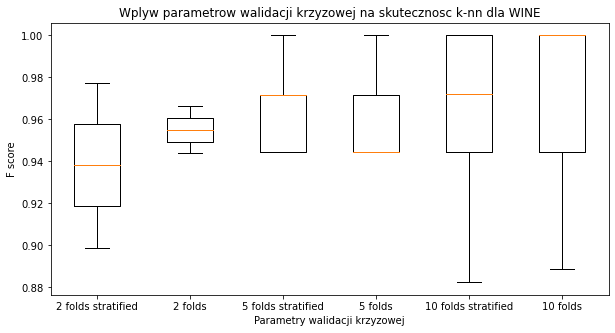

    Parameters  F1_score (mean)
6            7             0.98
9           10             0.97
10          11             0.97
3            4             0.96
5            6             0.96
7            8             0.96
11          12             0.96
14          15             0.96
15          16             0.96
0            1             0.95
4            5             0.95
8            9             0.95
12          13             0.95
13          14             0.95
2            3             0.94
1            2             0.93


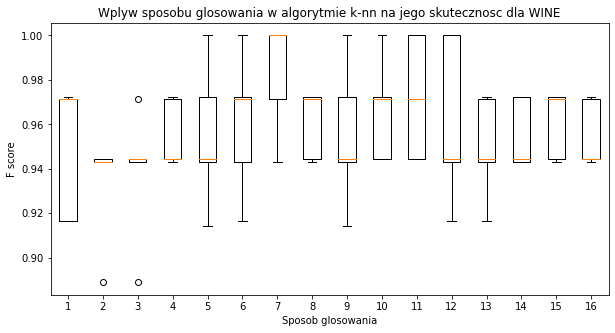

  Parameters  F1_score (mean)
1   distance             0.97
2    uniform             0.97
0    uniform             0.96


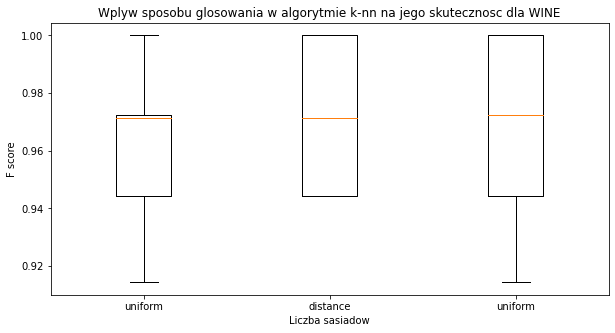

  Parameters  F1_score (mean)
1  manhattan             0.97
2  minkowski             0.97
0  euclidean             0.95


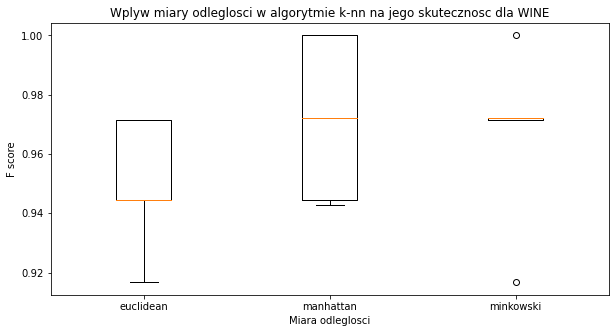

In [141]:
exp_crossvalidation_test('wine.data', 'Class identifier', wine_col_names, title='WINE')
exp_n_neighbors_test('wine.data', 'Class identifier', wine_col_names, title='WINE')
exp_voting_test('wine.data', 'Class identifier', wine_col_names, title='WINE', n_neighbors=5)
exp_metric_test('wine.data', 'Class identifier', wine_col_names, title='WINE', n_neighbors=5)

## GLASS

            Parameters  F1_score (mean)
2   5 folds stratified             0.88
3              5 folds             0.86
4  10 folds stratified             0.85
0   2 folds stratified             0.84
5             10 folds             0.84
1              2 folds             0.75


C:\Users\Robert\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 9 members, which is less than n_splits=10.
  warnings.warn(


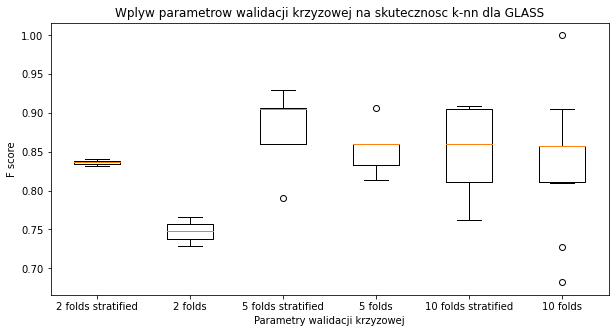

    Parameters  F1_score (mean)
2            3             0.87
0            1             0.86
4            5             0.86
3            4             0.85
5            6             0.83
6            7             0.83
1            2             0.82
8            9             0.82
12          13             0.82
10          11             0.81
7            8             0.80
9           10             0.80
11          12             0.80
13          14             0.78
14          15             0.78
15          16             0.77


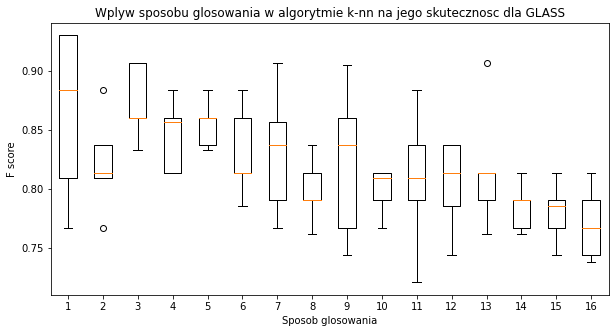

  Parameters  F1_score (mean)
1   distance             0.87
2    uniform             0.86
0    uniform             0.85


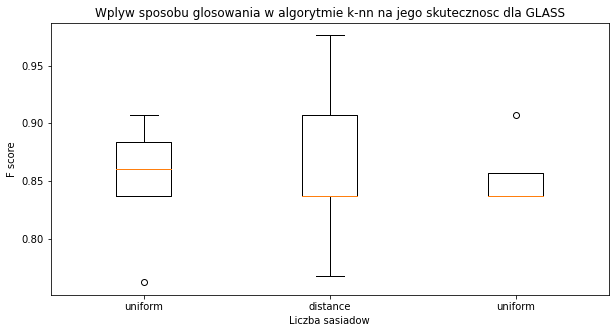

  Parameters  F1_score (mean)
1  manhattan             0.89
2  minkowski             0.85
0  euclidean             0.84


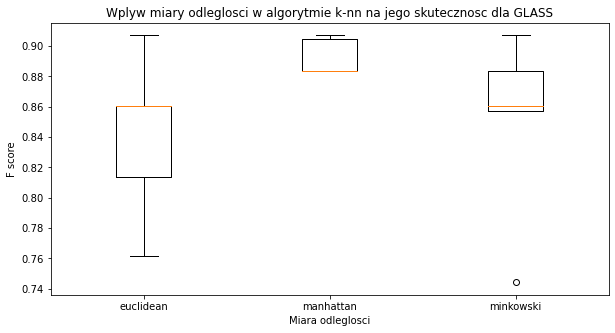

In [142]:
exp_crossvalidation_test('glass.data', 'type', glass_col_names, title='GLASS')
exp_n_neighbors_test('glass.data', 'type', glass_col_names, title='GLASS')
exp_voting_test('glass.data', 'type', glass_col_names, title='GLASS', n_neighbors=5)
exp_metric_test('glass.data', 'type', glass_col_names, title='GLASS', n_neighbors=5)